<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/DepthWise_Separable_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depthwise Separable Convolution 

## Introduction

Depthwise Separable Convolution is a convolutional technique used in convolutional neural networks to reduce the number of parameters of the model and improve computational performance.

In this notebook, we will use this technique to train our CNN and compare the results with the previous models we have built. Before that, let us explain what Depthwise Separable Convolution is and why it allows us to achieve better computational performance.

## How it works

While standard convolution performs the channelwise and spatial-wise computation in one step, Depthwise Separable Convolution splits the computation into two steps: depthwise convolution applies a single convolutional filter per each input channel and pointwise convolution is used to create a linear combination of the output of the depthwise convolution.

So, the Depthwise Separable Convolution deals with not only the spatial dimensions but also the depth dimension, which refers to the number of channels in an image. An input image may have 3 channels representing RGB colors, but after passing through a few convolutional layers, it may have multiple channels. Each channel can be thought of as a particular interpretation of the image. For example, the "red" channel interprets the "redness" of each pixel, the "blue" channel interprets the "blueness" of each pixel, and the "green" channel interprets the "greenness" of each pixel. An image with 64 channels has 64 different interpretations of that image.

Below you can see an example of depthwise convolution along one dimension.

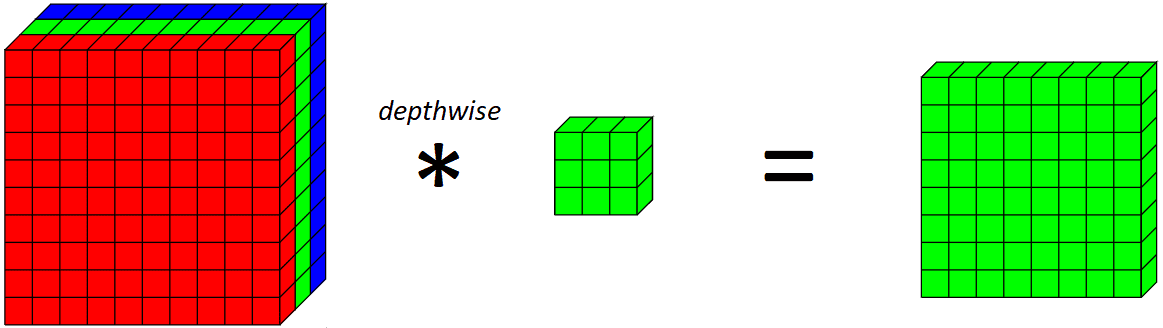

This operation must be applied to all dimensions of the image (e.g., height, width, and depth).
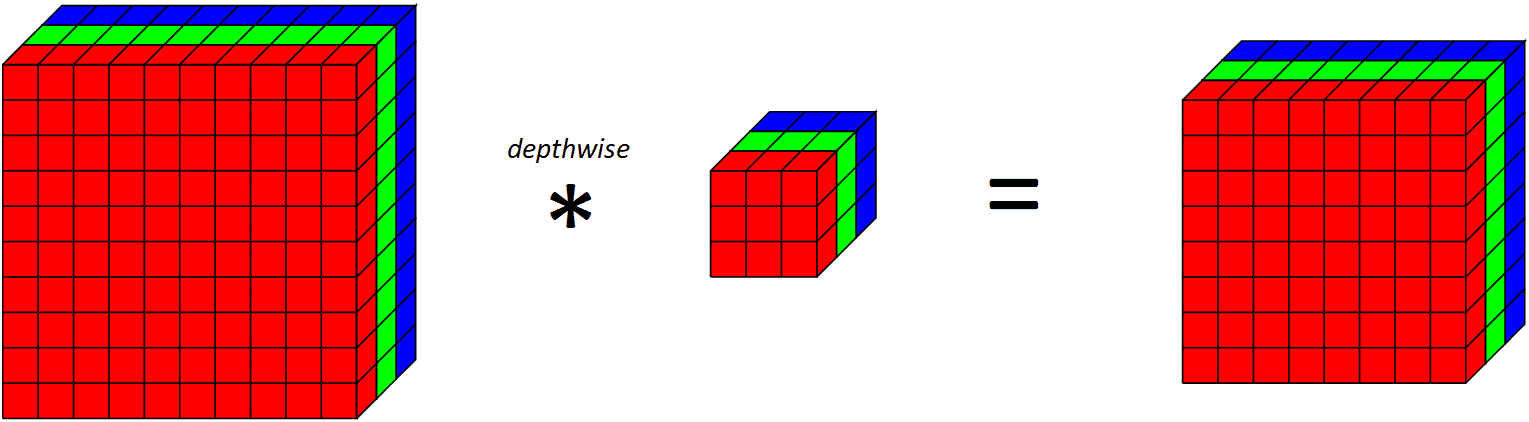

Once the convolution operation has been performed for all dimensions of the image, a pointwise convolution can be performed to aggregate the results into a single output. This involves computing the element-wise sum of the outputs for each channel of the image, resulting in a single output value.

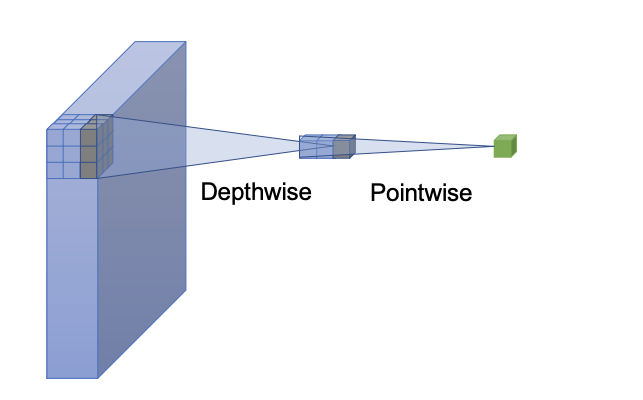

##Why using this technique?

These type of CNN’s are widely used because of the following two reasons –

* They have lesser number of parameters to adjust as compared to the standard CNN’s, which reduces overfitting
* They are computationally cheaper because of fewer computations which makes them suitable for mobile vision applications


#Setup

## Import libraries

In [1]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime

## Unzip preprocessed dataset

In [2]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/


## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [3]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/drive/My Drive/project/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

Our dataset contains images of various sizes. To ensure consistent inputs for the CNN, we need to resize the images to a standard size. 

In [4]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 128
NUM_CLASSES = 8
RANDOM_SEED = 42


In the chart above, we can see that the most popular image size in the dataset is 181x181. We therefore decided to set the IMAGE_WIDTH and IMAGE_HEIGHT variables with the most common values.

## Load dataset

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [6]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam'):

  if not os.path.exists(model_path):
    os.makedirs(model_path)

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,), 
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)    
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [7]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [8]:
def eval (model):
  y_score = model.predict(test_dataset)
  model.evaluate(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

  # ROC curve
  '''fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()'''

# Implementation 

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])


Loading of the best model defined from scratch in the previous notebook.

In [35]:
model_name = 'TwoDropout128Dense/TwoDropout128Dense.h5'
model = tf.keras.models.load_model(os.path.join(models_path, model_name))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                      

Our goal is to use the structure of this CNN and replace the Conv2D layers with SeparableConv2D layers, and then compare the results.

## Model definition

In [73]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.SeparableConv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.SeparableConv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 separable_conv2d_185 (Separ  (None, 224, 224, 32)     155       
 ableConv2D)                                                     
                                                                 
 max_pooling2d_159 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 separable_conv2d_186 (Separ  (None, 56, 56, 64)       2400      
 ableConv2D)                                                     
                                                          

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 2.0795 - accuracy: 0.1197
Epoch 1: val_loss improved from inf to 2.08000, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv/depthwise_separable_conv.h5
55/55 [==============================] - 21s 290ms/step - loss: 2.0795 - accuracy: 0.1197 - val_loss: 2.0800 - val_accuracy: 0.0632
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 2.0793 - accuracy: 0.1331
Epoch 2: val_loss did not improve from 2.08000
55/55 [==============================] - 16s 269ms/step - loss: 2.0793 - accuracy: 0.1331 - val_loss: 2.0813 - val_accuracy: 0.0692
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 2.0765 - accuracy: 0.1714
Epoch 3: val_loss improved from 2.08000 to 2.06963, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv/depthwise_separable_conv.h5
55/55 [==============================] - 18s 310ms/step - loss: 2.0765 - accuracy: 0.171

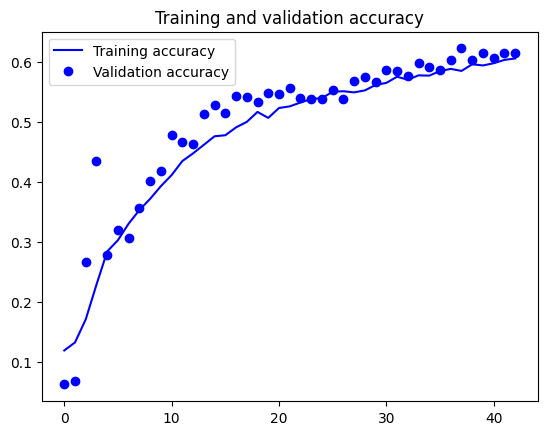

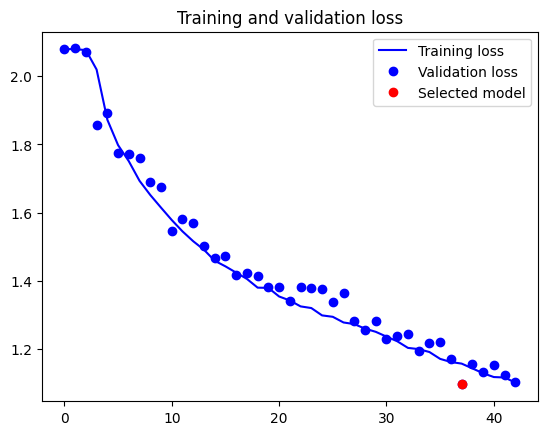

Lowest validation loss has been reached at epoch 37 with validation accuracy of 0.622


In [43]:
model_name = "depthwise_separable_conv"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 3s 169ms/step - loss: 1.4120 - accuracy: 0.5168
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[6 0 0 ... 0 7 0]
              precision    recall  f1-score   support

           0     0.0879    0.8095    0.1586       147
           1     0.9074    0.4406    0.5932      1112
           2     0.7831    0.2249    0.3495       289
           3     0.2667    0.1633    0.2025        98
           4     0.4380    0.3636    0.3974       165
           5     0.7123    0.1806    0.2881       288
           6     0.2941    0.0382    0.0676       131
           7     0.5312    0.3469    0.4198        98

    accuracy                         0.3613      2328
   macro avg     0.5026    0.3210    0.3096      2328
weighted avg     0.7055    0.3613    0.4306      2328



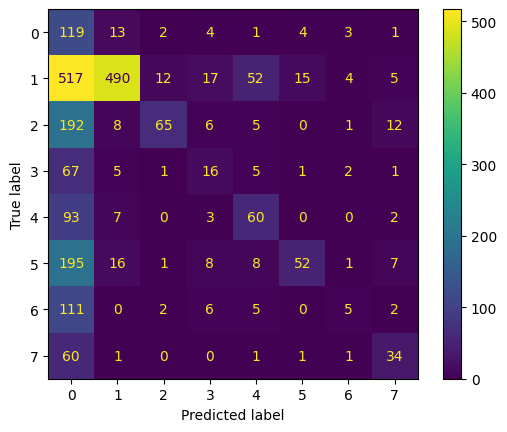

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

The results demonstrate that separable depthwise convolution is less powerful than normal convolution because, as explained above, it separates the convolution operation into two distinct parts. This separation of convolution operations into two phases can limit the network's ability to model complex relationships between different input channels; however, the complexity of the network has decreased considerably.

#Deeper Network

In [93]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.SeparableConv2D(filters=32, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.SeparableConv2D(filters=64, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=128, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=256, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 separable_conv2d_259 (Separ  (None, 224, 224, 32)     278       
 ableConv2D)                                                     
                                                                 
 max_pooling2d_211 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 separable_conv2d_260 (Separ  (None, 56, 56, 64)       4736      
 ableConv2D)                                                     
                                                          

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 2.0794 - accuracy: 0.1280
Epoch 1: val_loss improved from inf to 2.08035, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv_deeper/depthwise_separable_conv_deeper.h5
55/55 [==============================] - 22s 290ms/step - loss: 2.0794 - accuracy: 0.1280 - val_loss: 2.0804 - val_accuracy: 0.1328
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 2.0765 - accuracy: 0.1825
Epoch 2: val_loss improved from 2.08035 to 2.06801, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv_deeper/depthwise_separable_conv_deeper.h5
55/55 [==============================] - 17s 288ms/step - loss: 2.0765 - accuracy: 0.1825 - val_loss: 2.0680 - val_accuracy: 0.3326
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.9844 - accuracy: 0.2595
Epoch 3: val_loss improved from 2.06801 to 1.85494, saving model to /content/drive/My Drive/project/models/

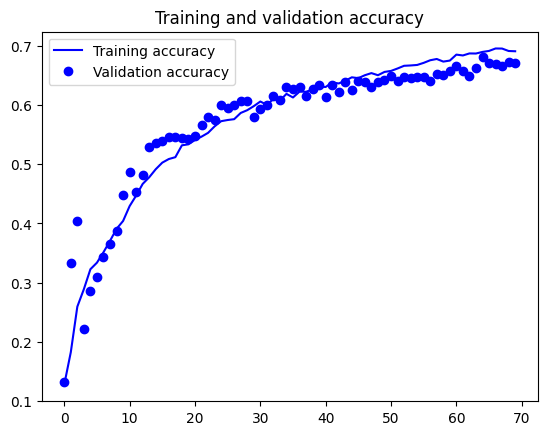

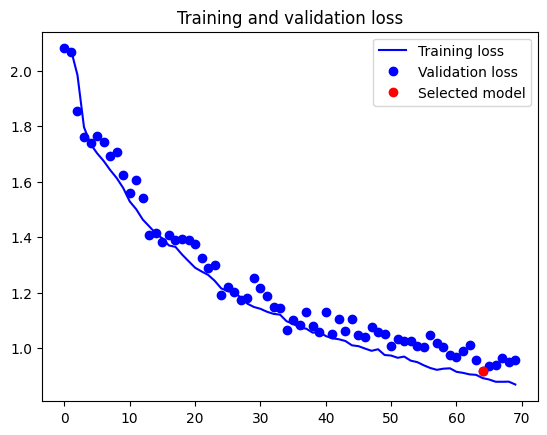

Lowest validation loss has been reached at epoch 64 with validation accuracy of 0.682


In [94]:
model_name = "depthwise_separable_conv_deeper"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 5s 282ms/step - loss: 0.8808 - accuracy: 0.7019
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 3]
              precision    recall  f1-score   support

           0     0.1734    0.8503    0.2880       147
           1     0.9664    0.6727    0.7932      1112
           2     0.8394    0.3979    0.5399       289
           3     0.4607    0.4184    0.4385        98
           4     0.6143    0.7818    0.6880       165
           5     0.7962    0.5833    0.6733       288
           6     0.6329    0.3817    0.4762       131
           7     0.6075    0.6633    0.6341        98

    accuracy                         0.6190      2328
   macro avg     0.6363    0.5937    0.5664      2328
weighted avg     0.7994    0.6190    0.6681      2328



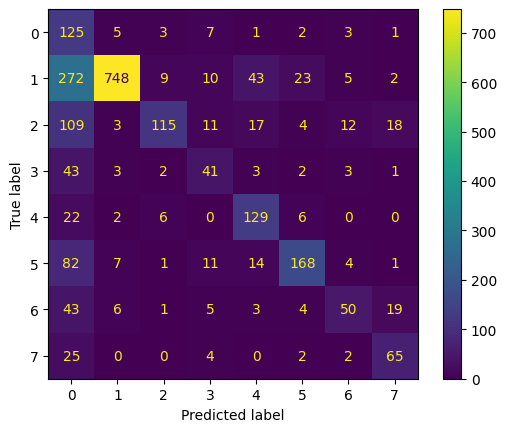

In [95]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

By slightly increasing the number of parameters and therefore the complexity of the model, the results are improved for both the validation set and the test set, in terms of accuracy and validation loss.

#Data Augmentation

In [97]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.2), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.1), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

In [98]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = layers.SeparableConv2D(filters=32, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.SeparableConv2D(filters=64, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=128, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=256, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_63 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 separable_conv2d_263 (Separ  (None, 224, 224, 32)     278       
 ableConv2D)                                                     
                                                                 
 max_pooling2d_215 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 separable_conv2d_264 (Separ  (None, 56, 56, 64)       473

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 2.0788 - accuracy: 0.1396
Epoch 1: val_loss improved from inf to 2.07939, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv_data_aug/depthwise_separable_conv_data_aug.h5
55/55 [==============================] - 34s 414ms/step - loss: 2.0788 - accuracy: 0.1396 - val_loss: 2.0794 - val_accuracy: 0.1070
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 2.0413 - accuracy: 0.2561
Epoch 2: val_loss improved from 2.07939 to 1.99530, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv_data_aug/depthwise_separable_conv_data_aug.h5
55/55 [==============================] - 17s 290ms/step - loss: 2.0413 - accuracy: 0.2561 - val_loss: 1.9953 - val_accuracy: 0.1057
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.8341 - accuracy: 0.2940
Epoch 3: val_loss improved from 1.99530 to 1.85151, saving model to /content/drive/My Drive/project

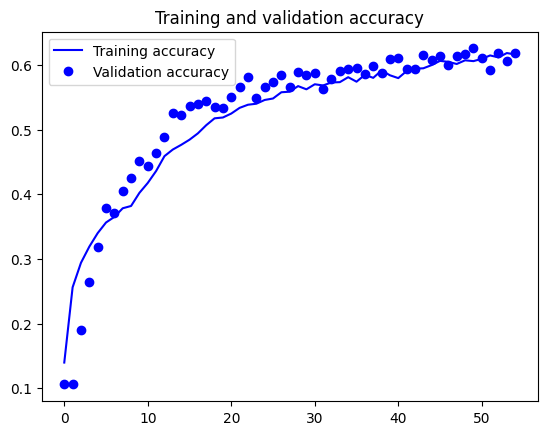

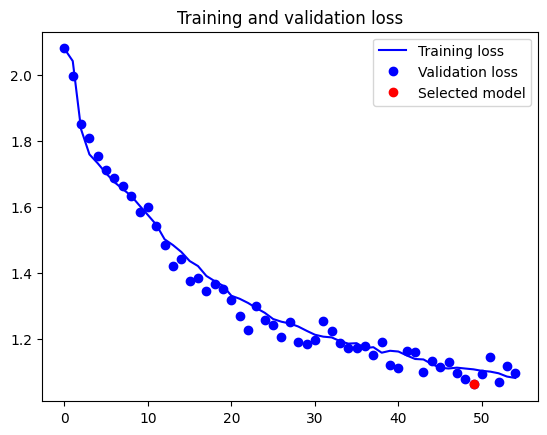

Lowest validation loss has been reached at epoch 49 with validation accuracy of 0.626


In [99]:
model_name = "depthwise_separable_conv_data_aug"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 3s 170ms/step - loss: 1.0302 - accuracy: 0.6353
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1406    0.8435    0.2410       147
           1     0.9541    0.6169    0.7493      1112
           2     0.8056    0.3010    0.4383       289
           3     0.2778    0.1531    0.1974        98
           4     0.6310    0.6424    0.6366       165
           5     0.6220    0.5312    0.5730       288
           6     0.6727    0.2824    0.3978       131
           7     0.5938    0.5816    0.5876        98

    accuracy                         0.5434      2328
   macro avg     0.5872    0.4940    0.4776      2328
weighted avg     0.7608    0.5434    0.5990      2328



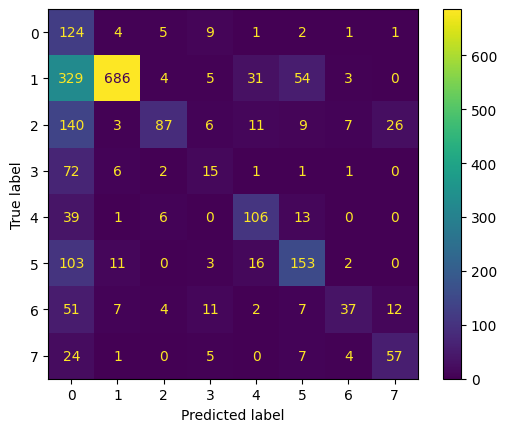

In [100]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations


Data augmentation does not seem to be helpful in this case. The model is already quite noisy and applying data augmentation results in even worse performance, both in terms of loss and accuracy on both the validation and test sets.

#Hyperparameter tuning

## Setup

In [108]:
!pip install -q -U keras-tuner

In [109]:
import keras_tuner as kt

my_dir = "/content/drive/My Drive/tuner"
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

## Model builder

In [110]:
def model_builder(hp):
  # Hyperparameter 
  activation_hp = hp.Choice('activation_function', values=['relu', 'elu', 'gelu'])
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  dropout_rate_hp1 = hp.Float('dropout_rate1', min_value = 0, max_value = 0.5)
  dropout_rate_hp2 = hp.Float('dropout_rate2', min_value = 0, max_value = 0.5)

  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  x = resize_and_rescale(inputs)
  x = layers.SeparableConv2D(filters=32, padding='same', kernel_size=3, depth_multiplier=2, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=4)(x)
  x = layers.SeparableConv2D(filters=64, padding='same', kernel_size=3, depth_multiplier=2, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=128, padding='same', kernel_size=3, depth_multiplier=2, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=256, padding='same', kernel_size=3, depth_multiplier=2, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(dropout_rate_hp1)(x)
  x = layers.Dense(hp_units1, activation='relu')(x)
  x = layers.Dense(hp_units2, activation='relu')(x)
  x = layers.Dropout(dropout_rate_hp2)(x)
  outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='depthwise_serable_conv_hptuning')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hyperparameter tuning

In [111]:
stop_early = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [112]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=25,
                     factor=3,
                     directory=log_dir,
                     project_name='model_tuned')

In [113]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
activation_function (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'gelu'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
dropout_rate2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}


Perform search for the best hyperparameters. 

In [ ]:
tuner.search(train_dataset, epochs=25, validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units1')}, \
        The optimal number of units in the second densely-connected layer is {best_hps.get('units2')}, \
        The optimal number of dropouts in the first layer is {best_hps.get('dropout_rate_hp1')}, \
        The optimal number of dropouts in the second layer is {best_hps.get('dropout_rate_hp2')}, \
        The optimal activation functionis {best_hps.get('activation_hp')}, \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

Trial 18 Complete [00h 04m 03s]
val_accuracy: 0.7009024620056152

Best val_accuracy So Far: 0.7009024620056152
Total elapsed time: 00h 31m 47s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
gelu              |gelu              |activation_function
32                |256               |units1
384               |128               |units2
0.01              |0.001             |learning_rate
0.19428           |0.4881            |dropout_rate1
0.39965           |0.13796           |dropout_rate2
9                 |25                |tuner/epochs
0                 |9                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/9
 6/55 [==>...........................] - ETA: 14s - loss: 2.0965 - accuracy: 0.1263

55/55 [==============================] - 28s 427ms/step - loss: 2.0901 - accuracy: 0.1226 - val_loss: 2.0834 - val_accuracy: 0.0567
Epoch 2/9
55/55 [==============================] - 23s 392ms/step - loss: 2.0817 - accuracy: 0.1162 - val_loss: 2.0950 - val_accuracy: 0.0623
Epoch 3/9
55/55 [==============================] - 24s 394ms/step - loss: 2.0809 - accuracy: 0.1234 - val_loss: 2.0820 - val_accuracy: 0.0623
Epoch 4/9
55/55 [==============================] - 24s 419ms/step - loss: 2.0804 - accuracy: 0.1197 - val_loss: 2.0931 - val_accuracy: 0.0623
Epoch 5/9
55/55 [==============================] - 24s 412ms/step - loss: 2.0805 - accuracy: 0.1176 - val_loss: 2.0830 - val_accuracy: 0.1298


In [ ]:
tuner.results_summary()

## Train model with the best hyperparameters

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=stop_early)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset, callbacks=stop_early)

In [ ]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)